In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla
import pandas as pd
import gc

In [3]:
def E0(layers):
    m1=[]
    for j in np.arange(0,8*layers,8):
        m1.append([(i+j,i+1+j) for i in range(7)])
    return np.array(m1).reshape(-1,2)
def E1(layers):
    m2=[]
    for j in np.arange(0,8*(layers-1),8):
        m2.append(np.array([((j+i,j+7+i),(j+i,j+7+2+i)) for i in np.arange(1,7,2)]))
    m2=np.array(m2).reshape(-1,2)
    return m2
def E2(layers):
    m3=[]
    m3.append([(j+7,j+14) for j in np.arange(0,8*(layers-1),8)])
    m3=np.array(m3).reshape(-1,2)
    return m3
def E3(layers):
    m4=[]
    m4.append([(8*layers+1,i) for i in np.arange(0,7,2)])
    return np.array(m4).reshape(-1,2)


def E4(layers):
    m5=[]
    m5.append([(layers*8,i) for i in np.arange((layers-1)*8+1,layers*8,2)])
    return np.array(m5).reshape(-1,2)

In [5]:
def create_graph(layers,seed):
    np.random.seed(seed)
    number_of_indices = 8*layers
    G = ntx.Graph()
    #G.add_nodes_from(range(8 * layers))
    e0 = E0(layers)
    e1 = E1(layers)
    e2 = E2(layers)
    e3 = E3(layers)
    e4 = E4(layers)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
    G.add_edges_from(e2)
  #  G.add_edges_from(e3)
  #  G.add_edges_from(e4)
#    G.add_edges_from(((0,11),(6,20)))
    return G

In [7]:
#print(list(create_3d_graph(4,1,2).neighbors((0,1))))

In [7]:
def create_3d_graph(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}  # Map old node to new sequential index

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    # Connect layers vertically (with the correction)
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect bottom layer even nodes to external_node_1
    for node in G_2d.nodes:
        if node % 2 == 0:
            G_3d.add_edge(node_mapping[(node, 0)], external_node_1)  # Bottom layer (z=0)

    # Connect top layer odd nodes to external_node_2
    for node in G_2d.nodes:
        if node % 2 == 1 and node < max(G_2d.nodes):
            G_3d.add_edge(node_mapping[(node, depth - 1)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2


In [11]:
create_3d_graph(4, 1, 10)

(<networkx.classes.graph.Graph at 0x746ec976f5d0>, 320, 321)

In [ ]:
print(list(create_3d_graph(4,1,2).neighbors(65)))

In [ ]:
# Extract node positions for plotting
#pos_3d = {node: (node[0], node[1]) for node in create_3d_graph(4, 1, 2).edges}  
#pos_3d

In [9]:
def generate_random_values(mean, std, seed, num_edges):
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))

In [11]:
def matrix_interactions(seed, depth, h, std,ext):

    grid,a,b = create_3d_graph(4, seed, depth)
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()

    h= int(h * num_edges)
    np.random.seed(seed)
    cap_values = np.abs(1 * np.concatenate((generate_random_values(1, std, seed, num_edges-h),generate_random_values(1, 0, seed, h)))) 
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values
    #print(cap_values)

    adjM = sc.lil_matrix((nodes, nodes))

    xxx = list(grid.edges())
    #print(xxx)

    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i == a or j == a or i == b or j == b:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = ext
            adjM[j, i] = ext
        else:
            #print(i,j,interactions[edge_idx])
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())

    return MI, a,b


In [ ]:
n,m,o = matrix_interactions(4,2,1,0)

In [ ]:
n

In [13]:
#matrix_interactions(seed, depth, h, std)
def R(seed,depth,h,std,ext):
    MI,a,b = matrix_interactions(seed,depth,h,std,ext)
    return MI[a, a] + MI[b, b] - MI[a,b] - MI[b, a] 

In [ ]:
#joop=[np.mean([R(seed,std) for seed in range(2)]) for std in np.arange(0.0,5,0.1)]

In [ ]:
#plt.plot(np.arange(0,5,0.1),joop)
#plt.xlabel('Std')
#plt.ylabel(r'$R_{oop}$')
#plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16')

In [15]:
# depth decides # no of flakes in the box
def create_3d_graph_ip(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}  # Map old node to new sequential index

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    # Connect layers vertically (with the correction)
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect side layer even nodes to external_node_1
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 0:
                G_3d.add_edge(node_mapping[(node, x)], external_node_1)  # side l

    # Connect side layer odd nodes to external_node_2
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 7 :
                G_3d.add_edge(node_mapping[(node, x)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2

In [17]:
def matrix_interactions_ip(seed, depth, h, std,ext):

    grid,a,b = create_3d_graph_ip(4, seed, depth)  # Assuming this function exists
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    np.random.seed(seed)
    #print(a,b)

    h= int(h * num_edges)
    np.random.seed(seed)

    cap_values = np.abs(1 * np.concatenate((generate_random_values(1, std, seed, num_edges-h),generate_random_values(0.0001, 0, seed, h))))      #hotspots
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values
    #print(round(cap_values,2))
    adjM = sc.lil_matrix((nodes, nodes))
    xxx = list(grid.edges())
    for edge_idx, (i, j) in enumerate(xxx):
        if i == a or j == a or i == b or j == b:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = ext
            adjM[j, i] = ext
        else:
            #print(i,j,interactions[edge_idx])
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
            
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    MI = spla.inv(-1 * adjM.tocsc())
    #print(MI.shape)

    return MI, a, b#, np.round(cap_values,2)
#matrix_interactions_ip(0, 2, 0.5, 0)

In [19]:
def R_ip(seed,depth,h,std,ext):
    MI,a,b = matrix_interactions_ip(seed, depth, h, std,ext)
    return MI[a, a] + MI[b, b] - MI[a,b] - MI[b, a] 

In [25]:
ratio(10,0.5,0)

NameError: name 'ratio' is not defined

In [33]:
r_out = {}
r_ip = {}
rat={}
def ratio(depth, h, std, ext):
    name = f'depth_{depth:2.2f}_hf_{h:2.2f}_std_{std:2.2f}_extr_{ext:2.2f}'

    
    R_o = [R(seed,depth,h,std,ext) for seed in range(500)]
    R_i = [R_ip(seed,depth,h,std,ext) for seed in range(500)]
    
    r_out[name] = R_o
    r_ip[name] = R_i
    
    # Calculate ratio
    r = (np.mean(R_o)/np.mean(R_i)) * (4.0 / depth**2)

    rat[name] = r
    # Save DataFrame
    
    return print(r)

In [43]:
ratio(10,0.5,0.5,1)

depth_10_hf_0.5_std_0.5_extr_1_exported


0.3702945322536622

In [23]:
import pandas as pd

In [ ]:
exr_R = [0.0001,1,10000]
depths = np.arange(5,50,5)
for exr in exr_R:
    for dep in depths:
        for h in np.arange(0,0.9,0.2):
            for std in np.arange(0,0.9,0.2):
                print(f'working on: depth_{dep}_hf_{h}_std_{std}_extr_{exr} ')
                ratio(dep,h,std,exr)

r1 = pd.DataFrame(r_out).to_csv(f'/home/shardul/arvind/resistances_test_rout.csv')
r2 = pd.DataFrame(r_ip).to_csv(f'/home/shardul/arvind/resistances_test_rip.csv')
r3 = pd.DataFrame(rat).to_csv(f'/home/shardul/arvind/resistances_test_ratio.csv')



working on: depth_5_hf_0.0_std_0.0_extr_0.0001 
0.20382852973507734
working on: depth_5_hf_0.0_std_0.2_extr_0.0001 
0.20382832081204
working on: depth_5_hf_0.0_std_0.4_extr_0.0001 
0.20382763846374438
working on: depth_5_hf_0.0_std_0.6000000000000001_extr_0.0001 
0.20382697079737738
working on: depth_5_hf_0.0_std_0.8_extr_0.0001 
0.20382660625062682
working on: depth_5_hf_0.2_std_0.0_extr_0.0001 
0.2038419863769556
working on: depth_5_hf_0.2_std_0.2_extr_0.0001 
0.2038416610680632
working on: depth_5_hf_0.2_std_0.4_extr_0.0001 
0.2038406212060071
working on: depth_5_hf_0.2_std_0.6000000000000001_extr_0.0001 
0.20383951753668916
working on: depth_5_hf_0.2_std_0.8_extr_0.0001 
0.20383905410053238
working on: depth_5_hf_0.4_std_0.0_extr_0.0001 
0.20384937287047453
working on: depth_5_hf_0.4_std_0.2_extr_0.0001 
0.20384895546248416
working on: depth_5_hf_0.4_std_0.4_extr_0.0001 
0.20384751856071437
working on: depth_5_hf_0.4_std_0.6000000000000001_extr_0.0001 
0.2038459750848522
working on

In [31]:
r1

In [55]:
def plot():
    for r in exr_R:
        for h in np.arange(0.1, 0.8, 0.1):
            for std in np.arange(0.0, 1, 0.1):
                name = f'lead_{r}_hotspot_{h:2.2f}_std_{std:2.2f}'
                print(name)
                df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function
    df.to_csv(f'/home/shardul/arvind/ca_all.csv', index=False)
    #print(f'Saved: /home/shardul/arvind/ca_all.csv')
    return df  # Return the final dataframe of the last iteration if needed

plot()

lead_0.0001_hotspot_0.10_std_0.00
lead_0.0001_hotspot_0.10_std_0.10
lead_0.0001_hotspot_0.10_std_0.20
lead_0.0001_hotspot_0.10_std_0.30
lead_0.0001_hotspot_0.10_std_0.40
lead_0.0001_hotspot_0.10_std_0.50
lead_0.0001_hotspot_0.10_std_0.60
lead_0.0001_hotspot_0.10_std_0.70
lead_0.0001_hotspot_0.10_std_0.80
lead_0.0001_hotspot_0.10_std_0.90
lead_0.0001_hotspot_0.20_std_0.00
lead_0.0001_hotspot_0.20_std_0.10
lead_0.0001_hotspot_0.20_std_0.20
lead_0.0001_hotspot_0.20_std_0.30
lead_0.0001_hotspot_0.20_std_0.40
lead_0.0001_hotspot_0.20_std_0.50
lead_0.0001_hotspot_0.20_std_0.60
lead_0.0001_hotspot_0.20_std_0.70
lead_0.0001_hotspot_0.20_std_0.80
lead_0.0001_hotspot_0.20_std_0.90
lead_0.0001_hotspot_0.30_std_0.00
lead_0.0001_hotspot_0.30_std_0.10
lead_0.0001_hotspot_0.30_std_0.20
lead_0.0001_hotspot_0.30_std_0.30
lead_0.0001_hotspot_0.30_std_0.40
lead_0.0001_hotspot_0.30_std_0.50
lead_0.0001_hotspot_0.30_std_0.60
lead_0.0001_hotspot_0.30_std_0.70
lead_0.0001_hotspot_0.30_std_0.80
lead_0.0001_ho

/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.40_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.50_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.60_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_1_hotspot_0.70_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.10_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.20_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.30_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.40_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.50_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.60_std_0.90


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.00


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.10


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.20


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.30


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.40


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.50


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.60


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.70


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.80


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


lead_10000_hotspot_0.70_std_0.90
Saved: /home/shardul/arvind/ca_all.csv


/tmp/ipykernel_45563/347217416.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = [ratio(x, h, std,r) for x in depths]  # Consider vectorizing ratio function


,lead_0.0001_hotspot_0.10_std_0.00,lead_0.0001_hotspot_0.10_std_0.10,lead_0.0001_hotspot_0.10_std_0.20,lead_0.0001_hotspot_0.10_std_0.30,lead_0.0001_hotspot_0.10_std_0.40,lead_0.0001_hotspot_0.10_std_0.50,lead_0.0001_hotspot_0.10_std_0.60,lead_0.0001_hotspot_0.10_std_0.70,lead_0.0001_hotspot_0.10_std_0.80,lead_0.0001_hotspot_0.10_std_0.90,...,lead_10000_hotspot_0.70_std_0.00,lead_10000_hotspot_0.70_std_0.10,lead_10000_hotspot_0.70_std_0.20,lead_10000_hotspot_0.70_std_0.30,lead_10000_hotspot_0.70_std_0.40,lead_10000_hotspot_0.70_std_0.50,lead_10000_hotspot_0.70_std_0.60,lead_10000_hotspot_0.70_std_0.70,lead_10000_hotspot_0.70_std_0.80,lead_10000_hotspot_0.70_std_0.90
0,0.203835,0.203835,0.203835,0.203835,0.203834,0.203834,0.203834,0.203833,0.203833,0.203833,...,954.428219,952.487315,945.944802,933.140076,913.078531,890.777898,878.108034,871.833364,868.718778,869.406772
1,0.099506,0.099506,0.099506,0.099505,0.099504,0.099503,0.099502,0.099502,0.099502,0.099502,...,1063.265154,1060.902143,1053.636291,1039.783068,1019.500023,996.699511,980.571480,972.646155,969.952305,971.354002
2,0.065808,0.065808,0.065808,0.065807,0.065806,0.065804,0.065804,0.065803,0.065803,0.065803,...,1090.914440,1088.516427,1081.106695,1067.039977,1045.932282,1023.879461,1007.332044,999.031806,996.303567,998.269158
3,0.049161,0.049161,0.049161,0.049160,0.049159,0.049157,0.049156,0.049155,0.049155,0.049155,...,1111.372177,1108.776145,1101.083845,1086.577899,1065.271814,1042.754396,1026.403131,1017.081189,1013.910995,1014.729179
4,0.039238,0.039238,0.039237,0.039236,0.039235,0.039233,0.039232,0.039232,0.039232,0.039232,...,1119.071627,1116.579228,1109.031471,1094.797117,1073.388122,1051.191542,1035.026582,1025.985354,1022.627335,1024.824723
5,0.032649,0.032649,0.032648,0.032647,0.032646,0.032645,0.032644,0.032643,0.032643,0.032643,...,1124.630820,1122.175772,1114.663215,1100.542738,1079.535805,1057.117426,1040.261519,1030.961851,1027.487931,1029.112687
6,0.027956,0.027956,0.027955,0.027954,0.027953,0.027951,0.027950,0.027950,0.027950,0.027950,...,1126.342431,1123.984305,1116.591414,1102.534617,1081.475182,1059.410438,1042.892993,1033.608298,1030.649476,1032.771172
7,0.024443,0.024443,0.024443,0.024442,0.024440,0.024439,0.024438,0.024437,0.024437,0.024437,...,1121.823474,1119.565284,1112.329997,1098.529826,1077.943037,1056.351900,1040.736662,1031.638370,1028.988795,1030.818152
8,0.021715,0.021715,0.021715,0.021714,0.021712,0.021711,0.021710,0.021709,0.021709,0.021709,...,1122.405455,1120.186179,1113.030584,1099.410104,1079.125986,1057.582767,1041.703033,1032.542983,1029.971941,1032.128095
9,0.019536,0.019536,0.019535,0.019534,0.019533,0.019531,0.019530,0.019530,0.019529,0.019530,...,1116.943174,1114.778672,1107.714701,1094.187329,1074.051737,1052.721270,1036.558120,1027.789069,1025.668493,1027.921659


In [57]:
df.to_csv(f'/home/shardul/arvind/ca_3.csv')

In [ ]:
l=[]
for h in np.arange(0.1,0.8,0.1):
    for std in np.arange(0.2,1,0.2):
        name = f'hotspot_{h:2.2f}_std_{std:2.2f}'
        l.append(name)
df.columns = l
df.head()

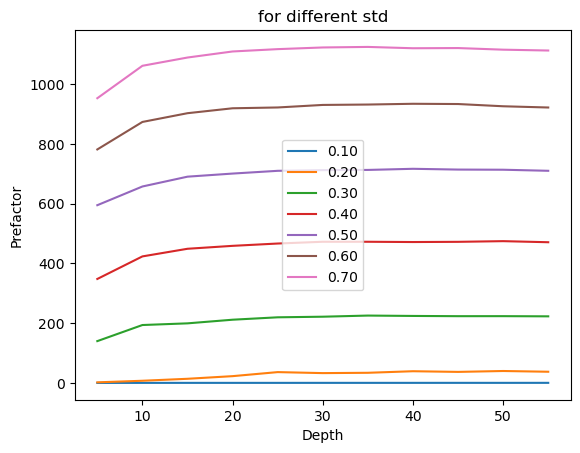

In [75]:
for std in np.arange(0.1,0.8,0.1):
    plt.plot(depths,df[f'lead_10000_hotspot_{std:2.2f}_std_{0.1:2.2f}'],label=f'{std:2.2f}')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('Prefactor')
plt.title(f'for different std')
plt.show()

In [ ]:
plt.plot(np.arange(0,5,0.1),df["Rop"],label=r'$R_{op}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{op}$',fontsize=15)
plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)


In [ ]:
plt.plot(np.arange(0,5,0.1),df["Rip"],label=r'$R_{ip}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{ip}$',fontsize=15)
plt.title(r'$R_{\mu} = 10$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)


In [ ]:
plt.plot(np.arange(0, 5, 0.1), df["ratio"], label=r'$\frac{R_{op}}{R_{ip}}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$\frac{R_{op}}{R_{ip}}$',fontsize=15)
plt.grid(True)


In [ ]:
def ratio_1(depth, h, std):
    R_o = R(1,depth,h,std)
    R_i = R_ip(1,depth,h,std)
    return (R_o/R_i) * (4.0/depth**2)

In [ ]:
ratio_1(50,0.2,0)

In [ ]:
MI1,a1,b1,cap_values1 = matrix_interactions_ip(1,2, 0.2, 0)
MI2,a2,b2,cap_values2 = matrix_interactions(1,2, 0.2, 0)

In [ ]:
np.round(cap_values2,3)

In [ ]:
np.round(cap_values1,3)

In [ ]:
df.to_csv(f'/home/shardul/arvind/ca.csv')

In [ ]:
def matrix_interactions(seed, depth, h, std):

    grid,a,b = create_3d_graph(4, seed, depth)
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()

    h= int(h * num_edges)

    cap_values = np.abs(1 * np.concatenate((generate_random_values(1, std, seed, num_edges-h),generate_random_values(1, 0, seed, h)))) 
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values
    #print(cap_values)

    adjM = sc.lil_matrix((nodes, nodes))

    xxx = list(grid.edges())
    #print(xxx)
    indexlist=[]
    for edge_idx, (i,j) in enumerate(xxx):
        if i == a or j == a or i == b or j == b:
            indexlist.append([i,j])
    

    return indexlist#,a,b

In [ ]:
matrix_interactions(1,2,0,0)